In [1]:
1

1

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import dartsort
import numpy as np
import dartsort.vis as dartvis
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA, TruncatedSVD
import spikeinterface.full as si
from dartsort.config import *
from dartsort.cluster import initial, density
import dataclasses
from dartsort.util import drift_util
import warnings
from tqdm.auto import trange, tqdm
from scipy.stats import chi2
from ephysx import spike_gmm, spike_lrgmm, spike_basic, ppca
from matplotlib import colors
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster

In [4]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import offset_copy
from matplotlib.patches import Ellipse, Rectangle, ConnectionPatch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import contextlib
import colorcet as cc

plt.rc("figure", dpi=300)
plt.rc("figure", figsize=(2, 2))
SMALL_SIZE = 5
MEDIUM_SIZE = 7
BIGGER_SIZE =  8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [5]:
# global
model_radius = 15.0
cfg = DARTsortConfig(
    matching_iterations=2,
    subtraction_config=SubtractionConfig(
        detection_thresholds=(12, 9, 6, 5),
        extract_radius=75.0,
        max_waveforms_fit=20_000,
        subtraction_denoising_config=FeaturizationConfig(
            denoise_only=True,
            input_waveforms_name="raw",
            output_waveforms_name="subtracted",
            tpca_fit_radius=model_radius,
        ),
        residnorm_decrease_threshold=20.0,
    ),
    matching_config=MatchingConfig(
        threshold=2500.0,
        max_waveforms_fit=20_000,
        extract_radius=75.0,
    ),
    template_config=TemplateConfig(
        denoising_fit_radius=model_radius,
        denoising_snr_threshold=100.0,
        superres_templates=False,
    ),
    clustering_config=ClusteringConfig(
        cluster_strategy="density_peaks",
        sigma_regional=25.0,
        noise_density=1.0,
        ensemble_strategy=None,
    ),
    split_merge_config=SplitMergeConfig(
        min_spatial_cosine=0.0,
        linkage="single",
        # linkage="weighted_template",
        split_strategy_kwargs=dict(
            channel_selection_radius=model_radius,
            max_spikes=10_000,
        ),
        merge_template_config=TemplateConfig(
            denoising_fit_radius=model_radius,
            denoising_snr_threshold=100.0,
            superres_templates=False,
        )
    ),
    featurization_config=FeaturizationConfig(
        tpca_fit_radius=model_radius,
        localization_radius=50.0,
        localization_model="dipole",
    ),
    motion_estimation_config=MotionEstimationConfig(
        max_dt_s=1000,
        window_scale_um=250,
        window_step_um=75,
        window_margin_um=-150,
        min_amplitude=15.0,
    ),
)

In [31]:
!ls /home/charlie/data/uhdzye57_20220204

/home/charlie/data/uhdzye57_20220204


In [29]:
rec = si.read_binary_folder("/home/charlie/data/uhdzye57_20220204")

NotADirectoryError: [Errno 20] Not a directory: '/home/charlie/data/uhdzye57_20220204/binary.json'

In [7]:
rec

BinaryFolderRecording: 384 channels - 30.0kHz - 1 segments - 121,155,313 samples 
                       4,038.51s (1.12 hours) - float32 dtype - 173.31 GiB

In [25]:
dartsort.subtract(
    rec,
    "/home/charlie/data/uhdzigzagzye57cmr_sub2",
    subtraction_config=cfg.subtraction_config,
    featurization_config=cfg.featurization_config,
    overwrite=True,
    # n_jobs=2,
    
)

Fit subtraction denoisers 1.0s/it [spk/it=%%%]:   0%|          | 0/100 [00:00<?, ?it/s]

Got 20047 spikes, enough to stop early.


Fit features 1.0s/it [spk/it=%%%]:   0%|          | 0/100 [00:00<?, ?it/s]

Got 20319 spikes, enough to stop early.


Subtraction 1.0s/it [spk/it=%%%]:   0%|          | 0/4039 [00:00<?, ?it/s]


KeyboardInterrupt



In [26]:
sub_st = dartsort.DARTsortSorting.from_peeling_hdf5(
    # "/home/charlie/data/uhdzigzagzye57cmr_sub/subtraction.h5",
    "/home/charlie/data/uhdzigzagzye57cmr_sub2/subtraction.h5",
    load_simple_features=True,
)
sub_st

DARTsortSorting: 872513 spikes, 1 unit. extra features: denoised_logpeaktotrough, denoised_peak_amplitude_vectors, denoised_ptp_amplitude_vectors, denoised_ptp_amplitudes, point_source_localizations, times_seconds. from parent h5 file /home/charlie/data/uhdzigzagzye57cmr_sub2/subtraction.h5.

In [13]:
motion_est = dartsort.estimate_motion(rec, sub_st, sub_st.parent_h5_path.parent, **dataclasses.asdict(cfg.motion_estimation_config))

Cross correlation:   0%|          | 0/3 [00:00<?, ?it/s]

Solve:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
chunk_time_ranges = initial.chunk_time_ranges(rec, chunk_length_samples=30_000 * 300)
chunk11_dpc = initial.cluster_chunk(sub_st.parent_h5_path, cfg.clustering_config, chunk_time_range_s=chunk_time_ranges[10], motion_est=motion_est)

In [28]:
chunk_time_ranges[11]

(3417.2011076923077, 3727.8557538461537)

In [15]:
chunk11_dpc

DARTsortSorting: 872513 spikes, 102 units. extra features: point_source_localizations, denoised_ptp_amplitudes, times_seconds. from parent h5 file /home/charlie/data/uhdzigzagzye57cmr_sub2/subtraction.h5.

In [16]:
def dpcvis(gmm, multi_only=False, unit_ids=None):
    if unit_ids is None:
        unit_ids = gmm.unit_ids()
    for uid in unit_ids:
        print(uid)
        z = gmm.train_loadings[uid]
        in_unit = gmm.train_spike_indices[uid]
        valid = np.flatnonzero(in_unit >= 0)
        in_unit = in_unit[valid]
        z = z[valid, :2]
        dens = density.density_peaks_clustering(
            z[:, :2],
            sigma_local="rule_of_thumb",
            # sigma_regional="rule_of_thumb",
            n_neighbors_search=500,
            return_extra=True,
        )
        if "density" not in dens:
            print("Clustering threw everyone away")
            continue
        ru = np.unique(dens["labels"])
        print("num units after split", ru[ru >= 0].size)
        if multi_only and ru[ru >= 0].size <= 1:
            continue
        fig, axes = dartvis.analysis_plots.density_peaks_study(z, dens, s=10)
        plt.show()
        plt.close(fig)

In [17]:
analysis_tcfg = dartsort.TemplateConfig(superres_templates=False, realign_peaks=False, denoising_snr_threshold=100.0, denoising_fit_radius=25.0)
analysis_tpca = None
def get_analysis(labels, keepers=None, base_sorting=None):
    if base_sorting is None:
        base_sorting=chunk11_dpc
    global analysis_tpca
    if analysis_tpca is None:
        analysis_tpca = dartsort.templates.get_templates.fit_tsvd(rec, base_sorting)

    if keepers is not None:
        labels_ = np.full_like(base_sorting.labels, -1)
        labels_[keepers] = labels
        labels = labels_
    sorting = dataclasses.replace(
        base_sorting,
        labels=labels,
    )
    return dartsort.DARTsortAnalysis.from_sorting(
        rec,
        sorting,
        motion_est=motion_est,
        allow_template_reload=False,
        template_config=analysis_tcfg,
        denoising_tsvd=analysis_tpca,
    )

In [18]:
geom = rec.get_channel_locations()

In [19]:
torch.set_grad_enabled(False)

In [20]:
def makeplots(i, subdir, gmm=None, sorting=None, n_jobs=0, with_summaries=True, with_dpcs=True):
    if gmm is None:
        a0 = get_analysis(sorting.labels)
    else:
        a0 = get_analysis(gmm.labels, gmm.data.keepers)
    fig = plt.figure(figsize=(15, 15))
    fig = dartvis.make_sorting_summary(a0, figure=fig);
    fig.savefig(subdir / "sorting.png", dpi=200)
    plt.close(fig)

    fig = plt.figure(figsize=(15, 15))
    fig, ax, ss = dartvis.scatter_spike_features(sorting=a0.sorting, show_triaged=False, figure=fig, width_ratios=[1, 1, 1]);
    fig.savefig(subdir / "scatter.png", dpi=200)
    plt.close(fig)

    if with_dpcs:
        (subdir / "dens").mkdir(exist_ok=True)
        for uid in tqdm(gmm.unit_ids()):
            z = gmm.train_loadings[uid]
            in_unit = gmm.train_spike_indices[uid]
            valid = np.flatnonzero(in_unit >= 0)
            in_unit = in_unit[valid]
            z = z[valid, :2]
            dens = density.density_peaks_clustering(
                z[:, :2],
                sigma_local="rule_of_thumb",
                # sigma_regional="rule_of_thumb",
                n_neighbors_search=500,
                return_extra=True,
            )
            if "density" not in dens:
                print("Clustering threw everyone away")
                continue
            ru = np.unique(dens["labels"])
            fig, axes = dartvis.analysis_plots.density_peaks_study(z, dens, s=10)
            fig.savefig(subdir / "dens" / f"{uid:04d}.png", dpi=200)
            plt.close(fig)

    if with_summaries:
        dartvis.make_all_summaries(
            a0,
            subdir / "summaries",
            channel_show_radius_um=15,
            overwrite=True,
            n_jobs=n_jobs)



In [21]:
figdir = Path("~/data/gmmfigs").expanduser()
figdir.mkdir(exist_ok=True)

In [27]:
subdir = figdir / f"newsub_chunk11dpc"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=True)

Denoised templates:   0%|          | 0/65 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/81 [00:00<?, ?pair block/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/65 [00:00<?, ?it/s]

In [22]:
gmm = spike_basic.BasicSpikePCAClusterer(
    chunk11_dpc,
    motion_est=motion_est,
    centered=True,
    rank=2,
    in_memory=True,
    fit_radius=15.0,
    wf_radius=15.0,
    whiten_input=True,
)
gmm.cuda()
gmm.m_step()
# gmm.dpc_split()

0.8% in 37 too-small units


Fit:   0%|          | 0/65 [00:00<?, ?it/s]

In [48]:
overlaps, rel_ix, static_channels_b = gmm.centroid_overlaps()

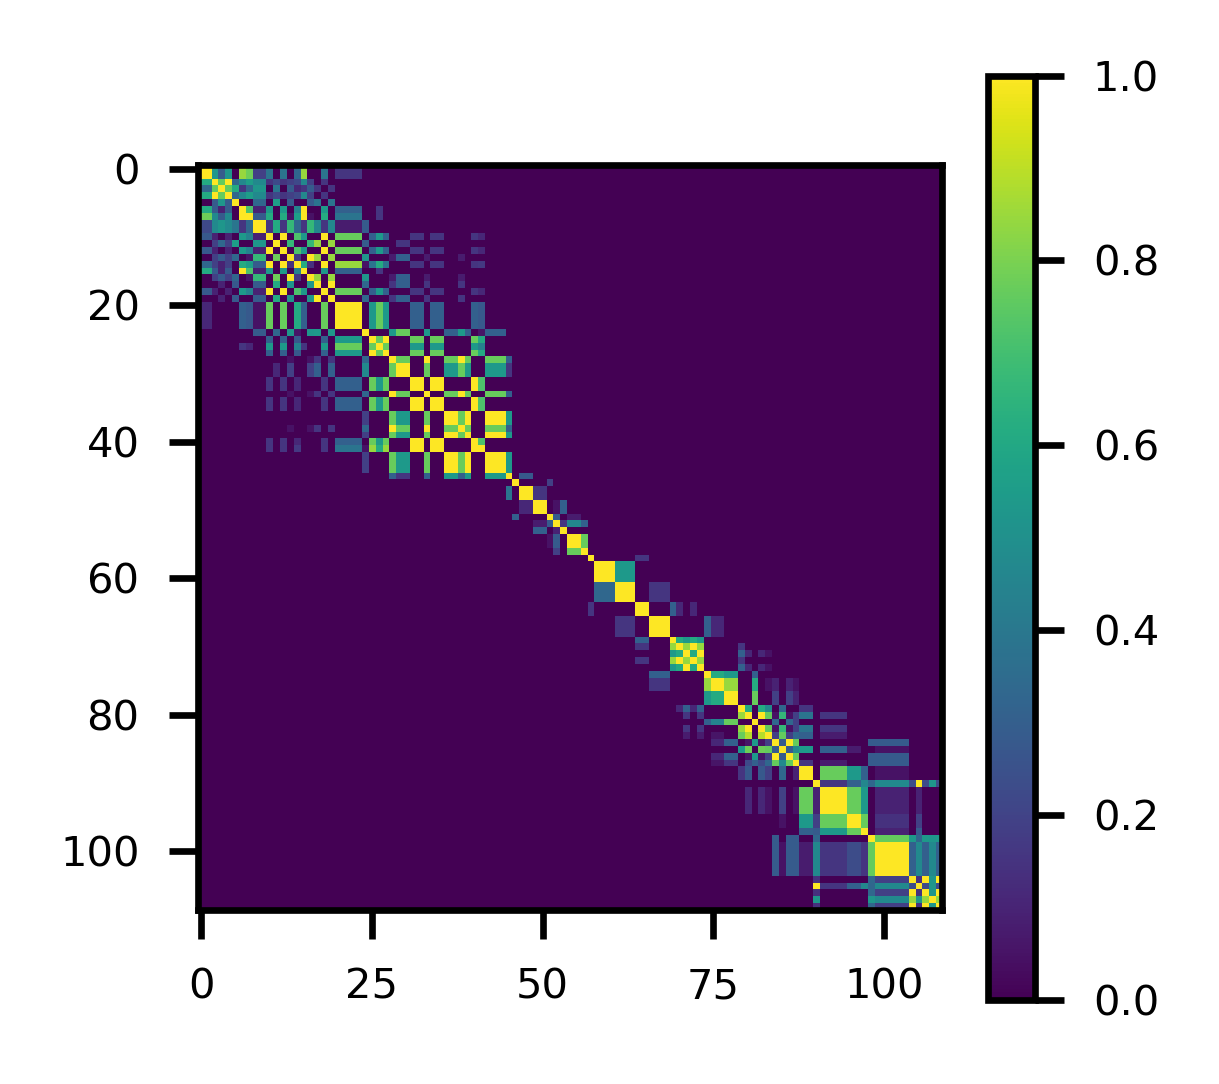

In [21]:
plt.imshow(overlaps)
plt.colorbar()

In [65]:
lres = gmm.centroid_likelihoods()
cres = gmm.centroid_likelihoods(centroid_only=True)

In [82]:
cres["mahals"][6]

array([66.65608215, 64.7930069 ,         inf,         inf,         inf,
               inf,  0.        , 90.20801544,         inf,         inf,
       29.83380127,         inf, 31.94803047,         inf,         inf,
       92.15982819,         inf,         inf, 36.63697052,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,      

In [84]:
chi2.cdf(cres["mahals"], df=cres["nobs"])[6]

array([4.38606922e-09, 1.41411855e-09,            nan,            nan,
                  nan,            nan, 0.00000000e+00, 1.35700222e-04,
                  nan,            nan, 6.14698239e-14,            nan,
       7.72299994e-13,            nan,            nan, 2.09639819e-01,
                  nan,            nan, 9.77307588e-11,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
      

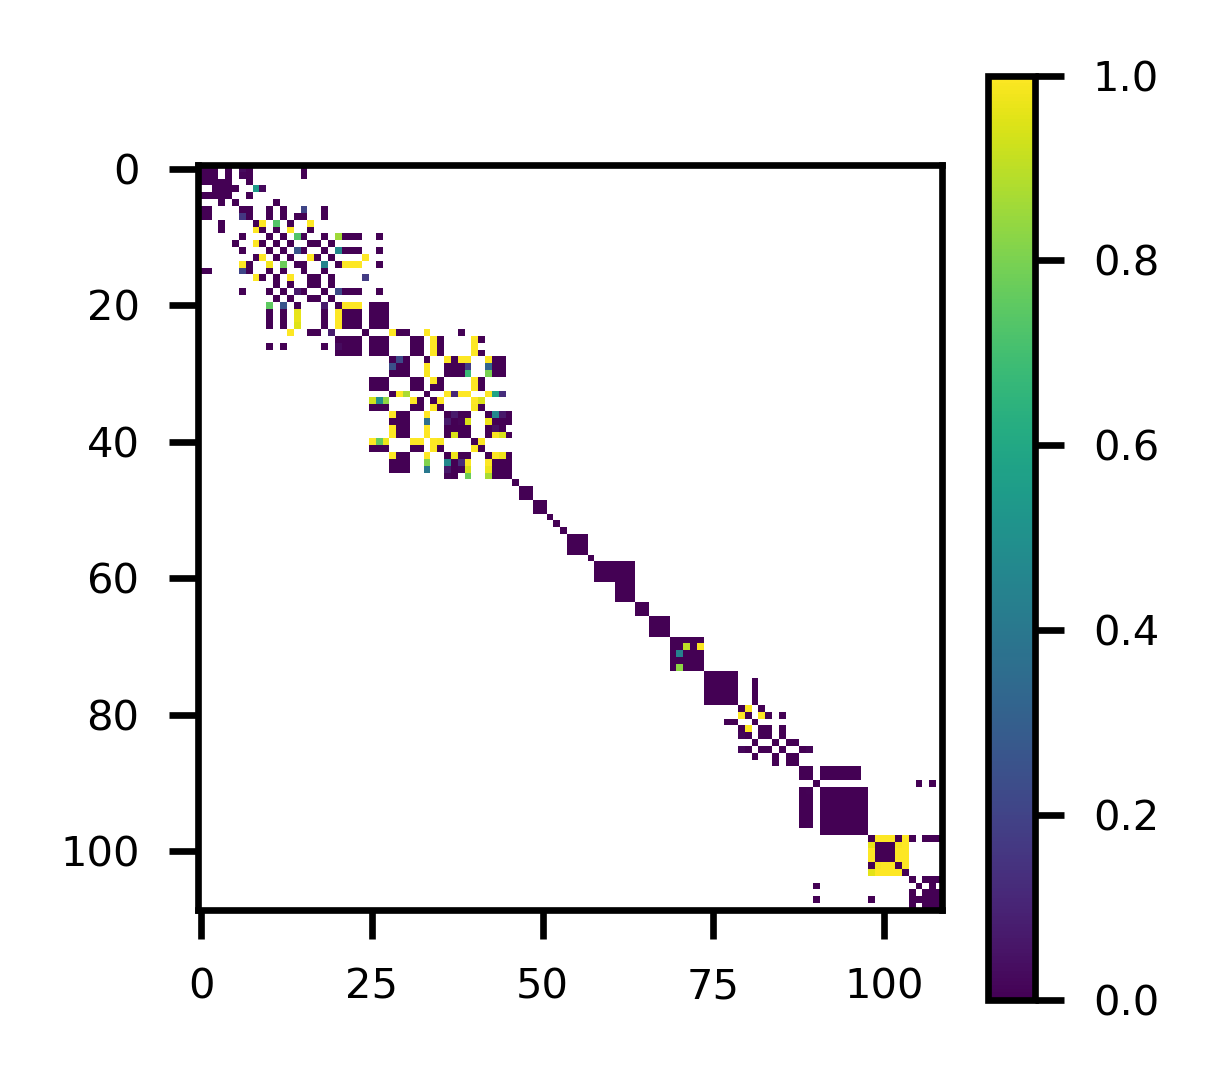

In [78]:
plt.imshow(chi2.cdf(cres["mahals"], df=cres["nobs"]))
plt.colorbar()

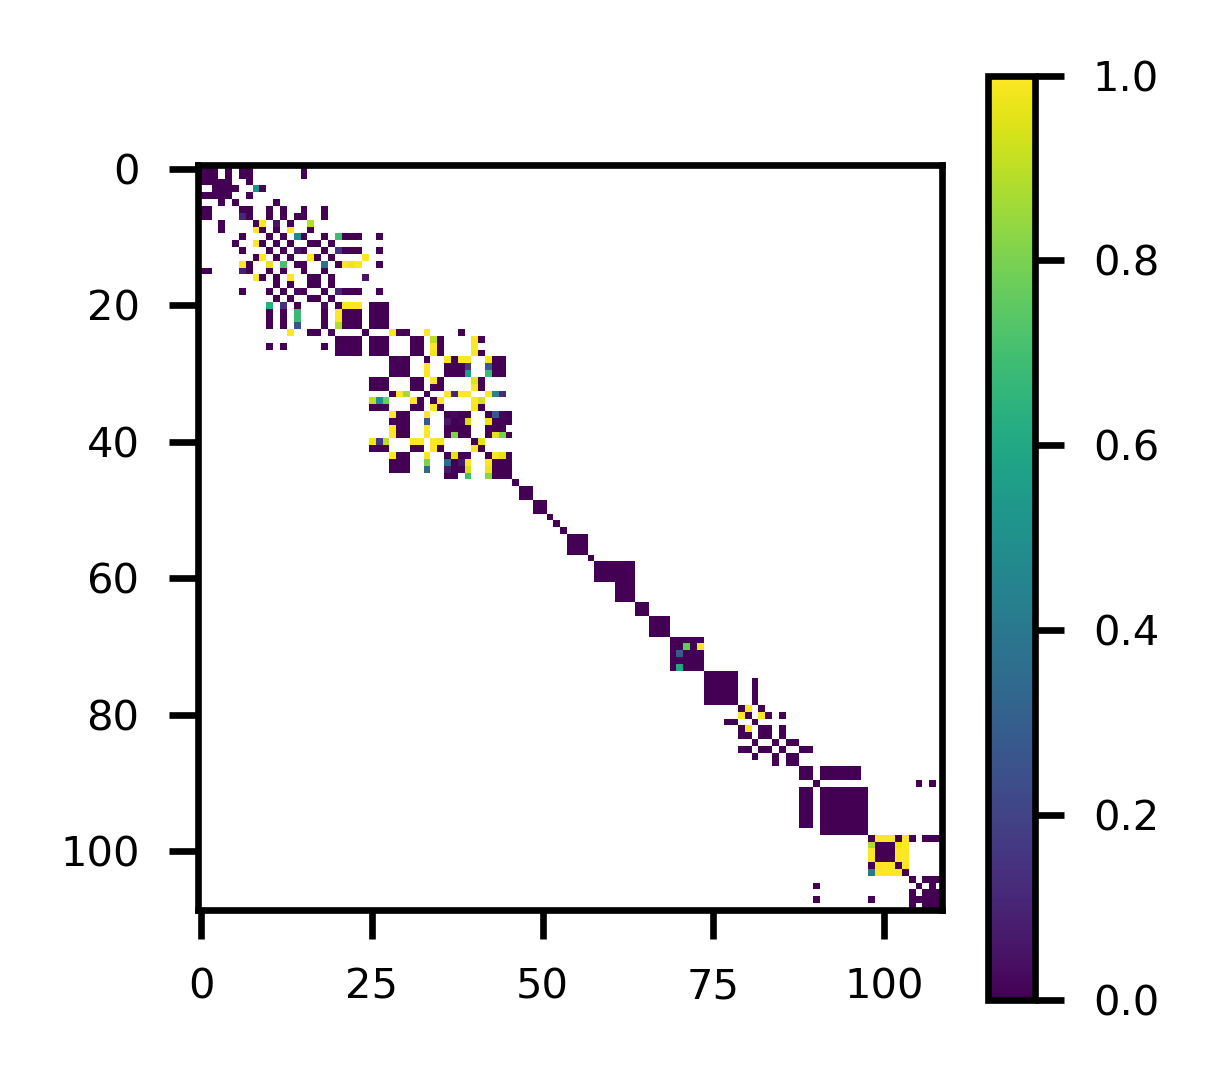

In [81]:
plt.imshow(chi2.cdf(lres["mahals"], df=lres["nobs"]))
plt.colorbar()

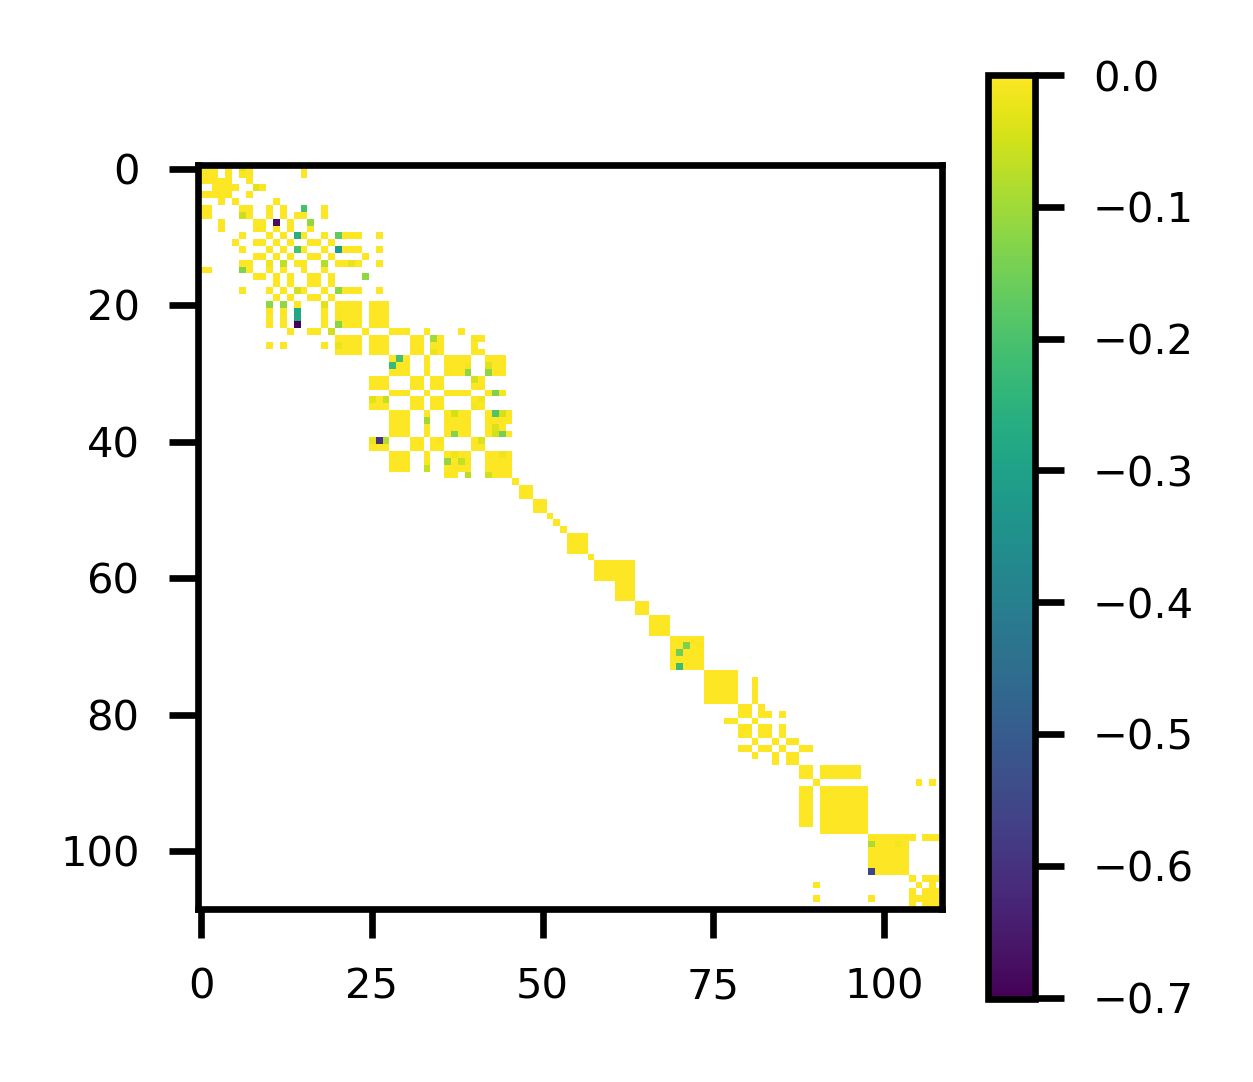

In [80]:
plt.imshow(chi2.cdf(lres["mahals"], df=lres["nobs"]) - chi2.cdf(cres["mahals"], df=cres["nobs"]))
plt.colorbar()

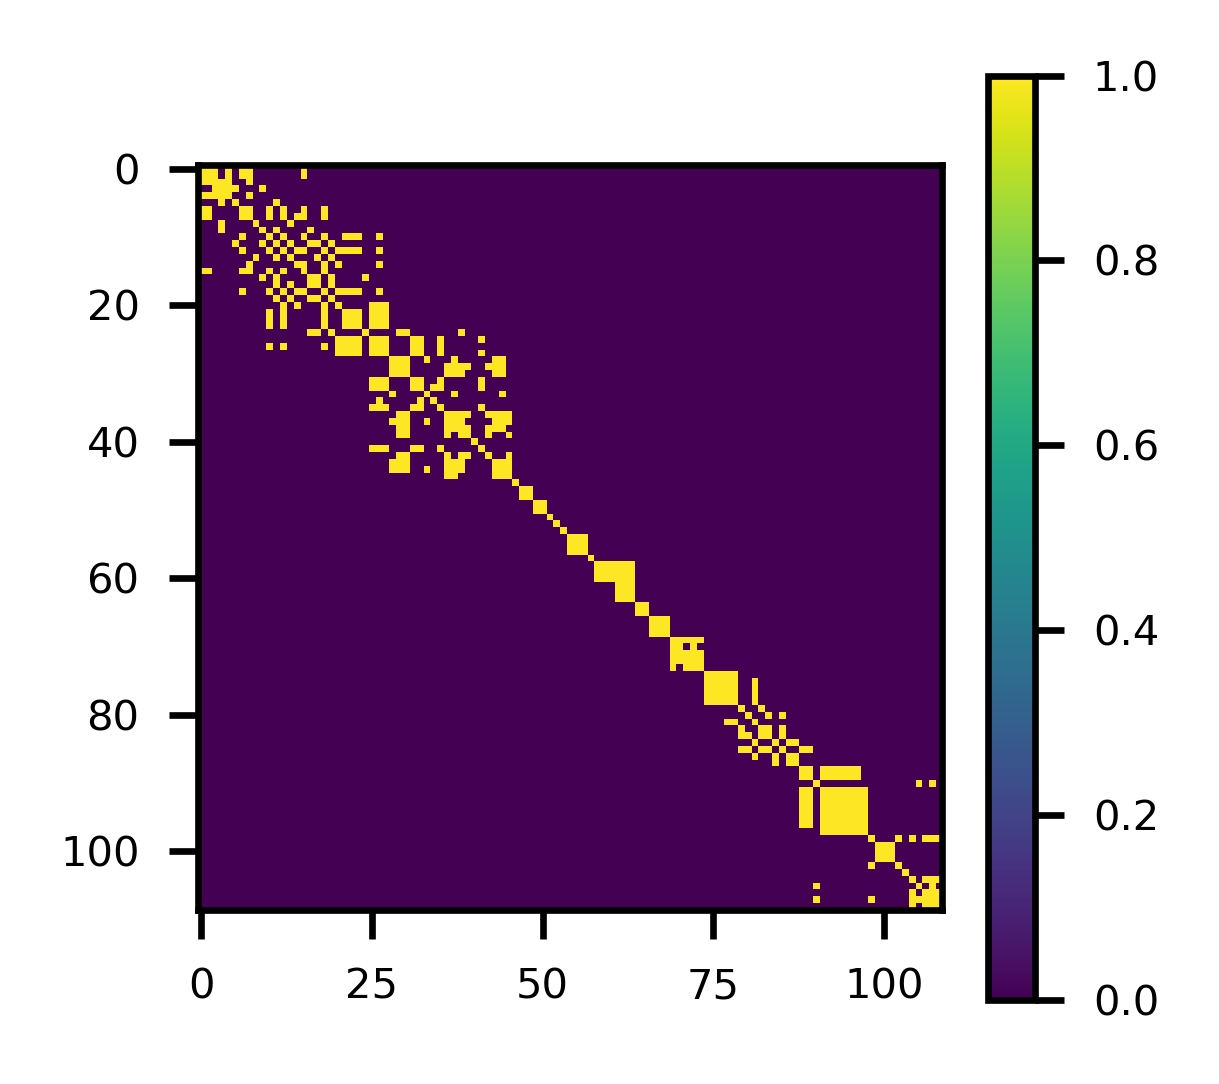

In [74]:
plt.imshow(cres["chis"] < 1); plt.colorbar()

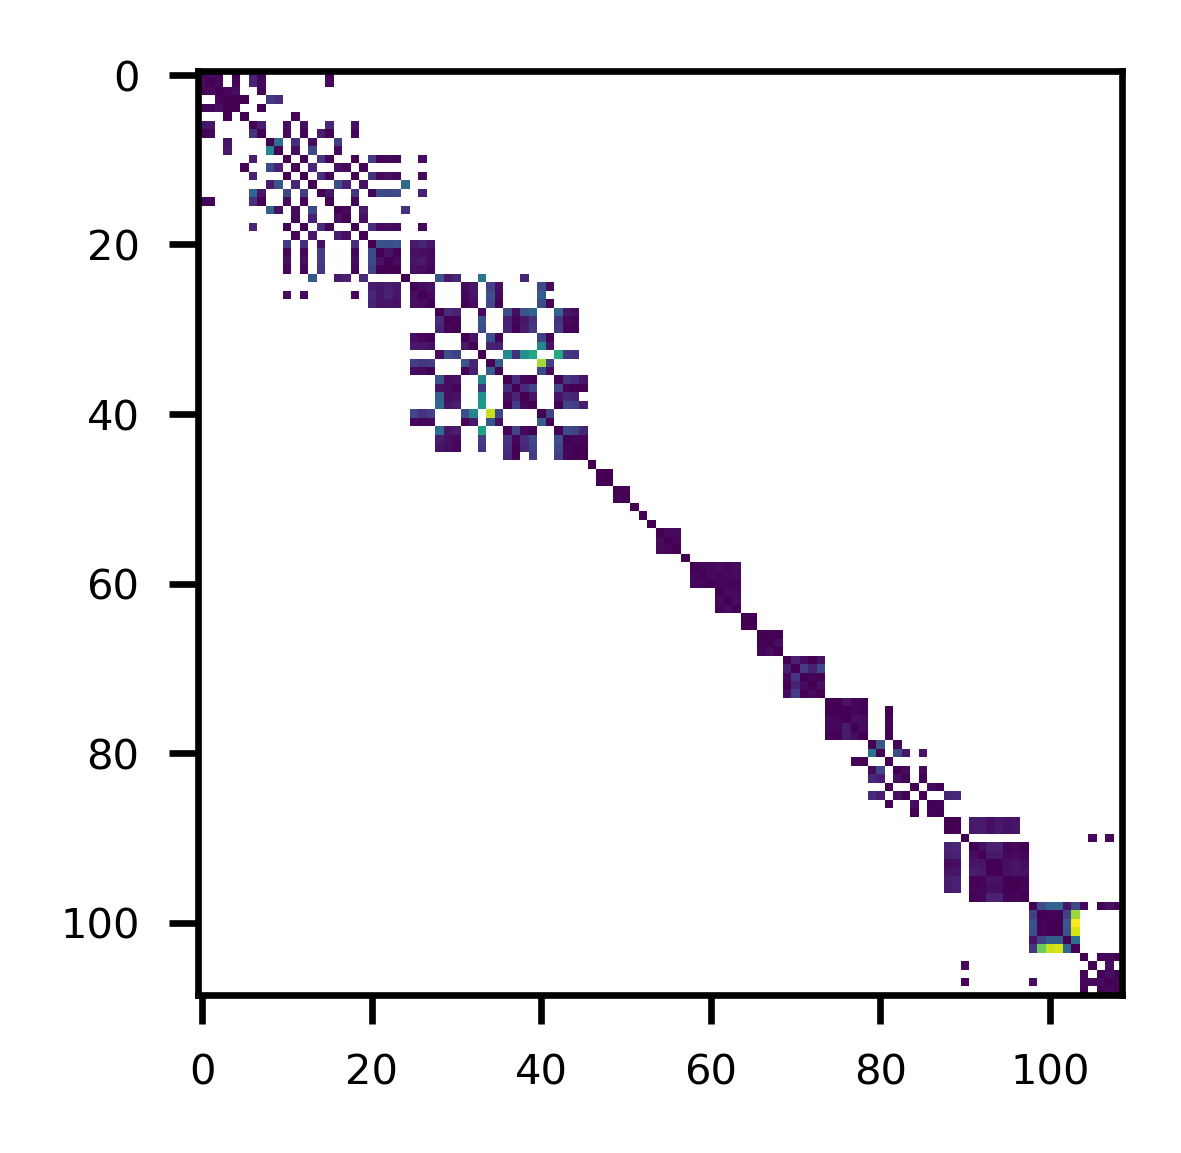

In [71]:
plt.imshow(lres["chis"])

In [24]:
m = gmm.mean.numpy(force=True)

In [28]:
rel_ix[107, 108]

array([ 2, 21,  5,  6,  7, 10, 11, 12, 15, 16, 17, 20, 21, 21, 21, 21, 21,
       21, 21, 21, 21])

In [30]:
scb[107]

array([388, 389, 390, 395, 396, 397, 398, 399, 403, 404, 405, 406, 407,
       411, 412, 413, 414, 415, 420, 421, 422])

In [31]:
scb[108]

array([390, 391, 397, 398, 399, 405, 406, 407, 413, 414, 415, 422, 423,
       592, 592, 592, 592, 592, 592, 592, 592])

In [32]:
rg = np.pad(gmm.data.registered_geom, [(0, 1), (0, 0)], constant_values=np.nan)

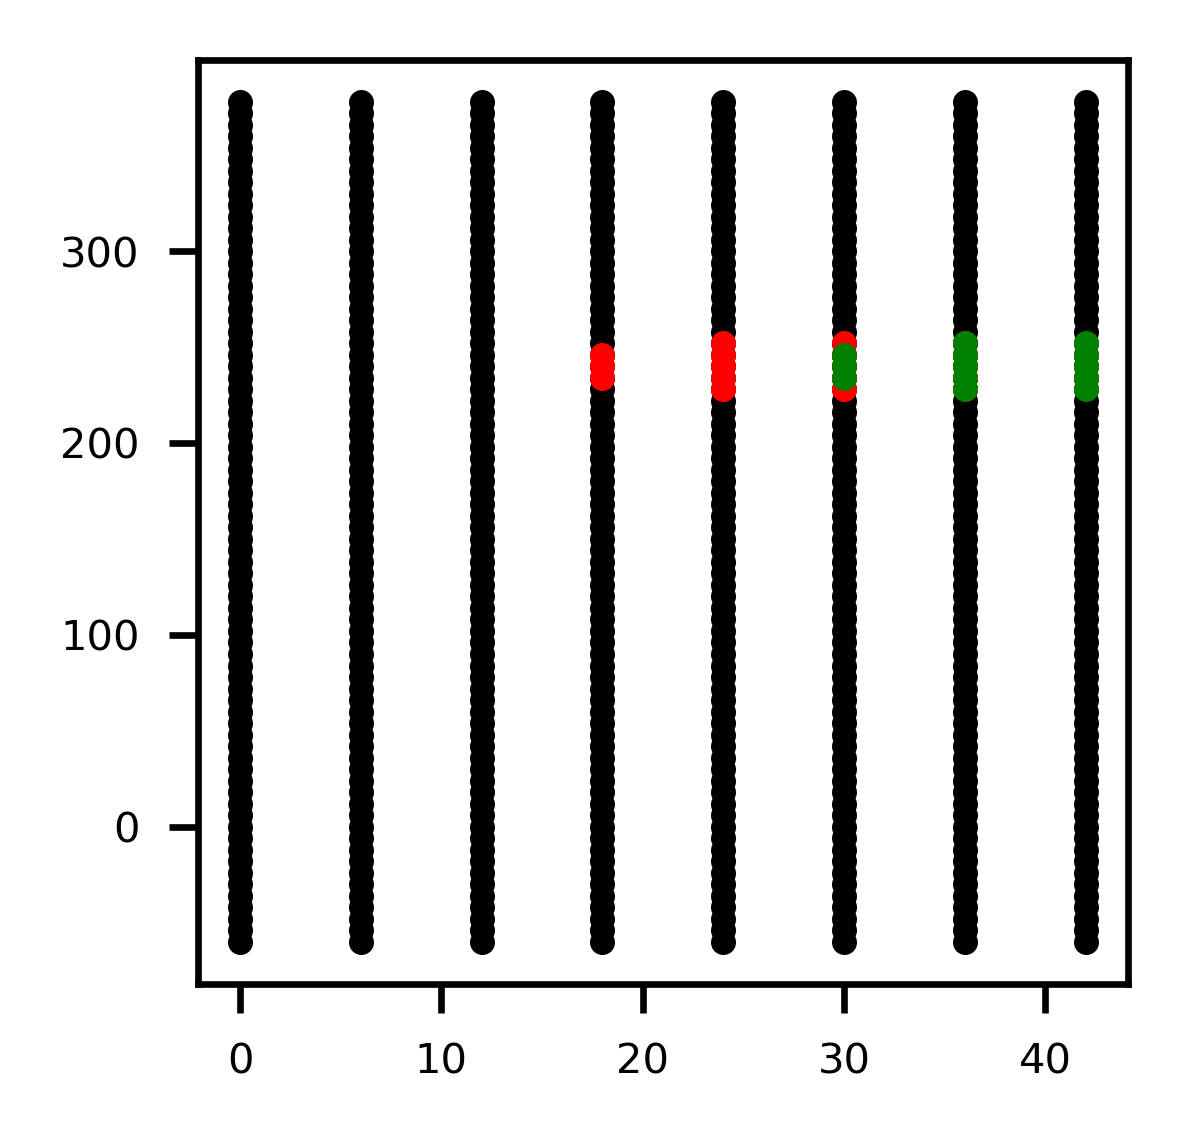

In [37]:
plt.scatter(*rg.T, color="k", lw=0, marker=".")
plt.scatter(*rg[scb[107]].T, color="r", lw=0, marker=".")
plt.scatter(*rg[scb[108]].T, color="g", lw=0, marker=".")

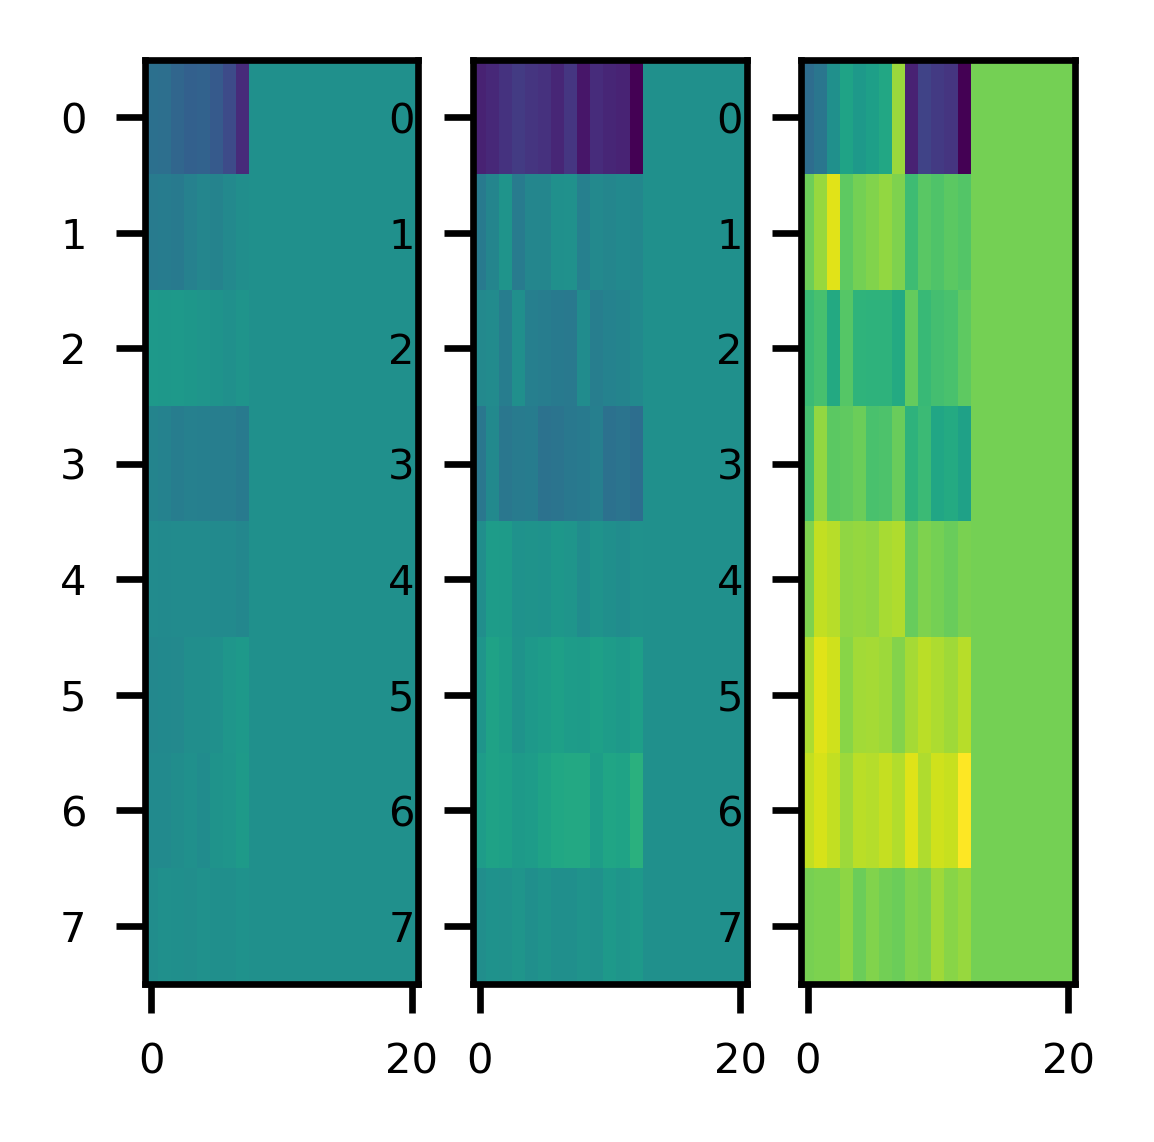

In [27]:
fig, (aa, ab, ac) = plt.subplots(ncols=3)
vm = np.abs(m[107:109]).max()
aa.imshow(m[108].reshape(8, -1), vmin=-vm, vmax=vm, aspect="auto")
ab.imshow(m[107].reshape(8, -1), vmin=-vm, vmax=vm, aspect="auto")
ac.imshow((m[107] - m[108]).reshape(8, -1), aspect="auto")

In [41]:
pairs = cres["overlaps"] > 0.5

In [42]:
unit_a = 95
row_a = pairs[unit_a]

In [44]:
units_b = np.flatnonzero(row_a)

In [55]:
unit_a, units_b[0]

(95, 88)

In [49]:
centroids_b = gmm.mean[units_b]
rel_ix_b = torch.tensor(rel_ix[unit_a, units_b]).to(centroids_b.device)
scb = static_channels_b[units_b]

In [51]:
centroid_a_rel = gmm.centroid_to_spike_channels(
    unit_a, rel_ix_b
)
comps_a_rel = None
sds = None

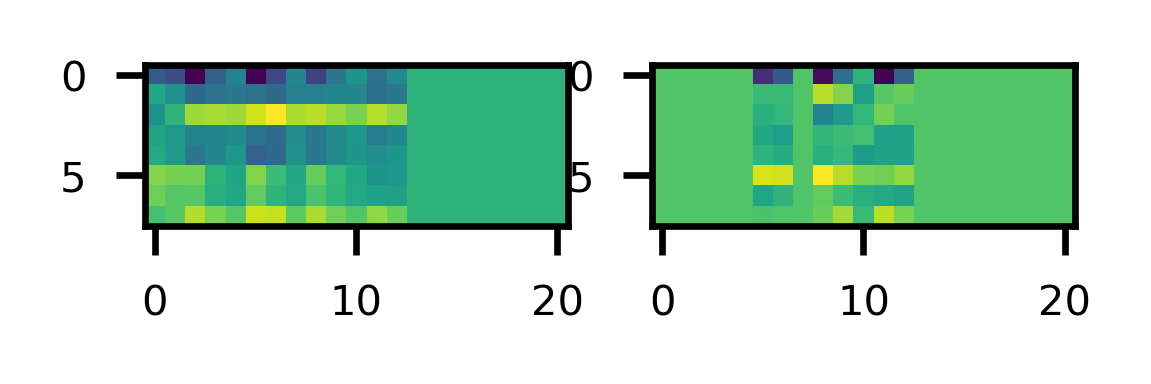

In [54]:
fig, (aa, ab) = plt.subplots(ncols=2)
aa.imshow(centroids_b[0].numpy(force=True).reshape(8,-1))
ab.imshow(centroid_a_rel[0].numpy(force=True).reshape(8,-1))

In [59]:
nb = units_b.size

In [61]:
rc = np.prod(centroids_b.shape[1:])
X = centroids_b.reshape(nb, rc)
masks = torch.tensor(scb < gmm.data.n_chans_cluster, device=X.device)
masks = masks.unsqueeze(1).broadcast_to(nb, gmm.data.tpca_rank, gmm.data.n_chans_cluster).reshape(X.shape)
centroid_a_rel = centroid_a_rel.reshape(nb, rc)

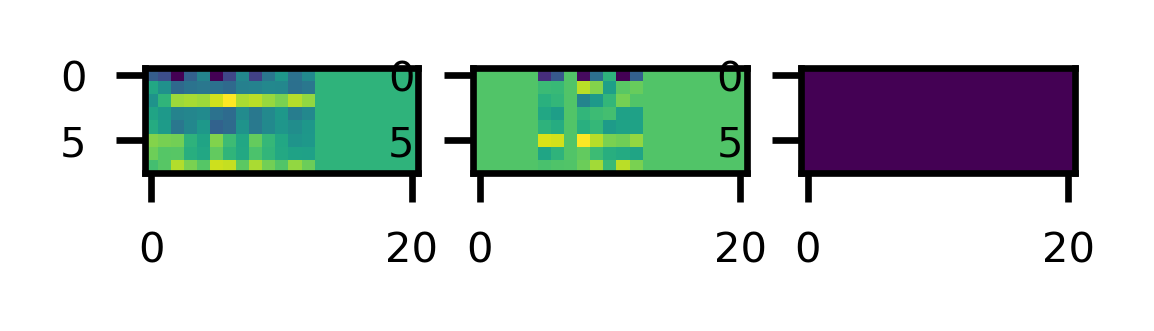

In [63]:
fig, (aa, ab, ac) = plt.subplots(ncols=3)
aa.imshow(X[0].numpy(force=True).reshape(8,-1))
ab.imshow(centroid_a_rel[0].numpy(force=True).reshape(8,-1))
ac.imshow(masks[0].numpy(force=True).reshape(8,-1))

In [64]:
masks

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

In [56]:
cres["mahals"][95, 88]

0.0

In [57]:
overlaps[95, 88]

0.5384615384615384

In [27]:
rel_ix.shape

(109, 109, 21)

In [35]:
split_labels = {}
for w in (False, True):
    if w in split_labels:
        continue
    gmm = spike_basic.BasicSpikePCAClusterer(
        chunk11_dpc,
        motion_est=motion_est,
        centered=True,
        rank=2,
        in_memory=True,
        fit_radius=15.0,
        wf_radius=15.0,
        whiten_input=w,
    )
    gmm.cuda()
    gmm.m_step()
    gmm.dpc_split()
    split_labels[w] = gmm.labels.copy()

0.1% in 11 too-small units


Fit:   0%|          | 0/80 [00:00<?, ?it/s]

Split round 1:   0%|          | 0/80 [00:00<?, ?it/s]

Fit:   0%|          | 0/128 [00:00<?, ?it/s]

Split round 2:   0%|          | 0/128 [00:00<?, ?it/s]

Fit:   0%|          | 0/117 [00:00<?, ?it/s]

Split round 3:   0%|          | 0/117 [00:00<?, ?it/s]

Fit:   0%|          | 0/57 [00:00<?, ?it/s]

Split round 4:   0%|          | 0/57 [00:00<?, ?it/s]

Fit:   0%|          | 0/31 [00:00<?, ?it/s]

Split round 5:   0%|          | 0/31 [00:00<?, ?it/s]

Fit:   0%|          | 0/19 [00:00<?, ?it/s]

Split round 6:   0%|          | 0/19 [00:00<?, ?it/s]

Fit:   0%|          | 0/10 [00:00<?, ?it/s]

Split round 7:   0%|          | 0/10 [00:00<?, ?it/s]

Fit:   0%|          | 0/6 [00:00<?, ?it/s]

Split round 8:   0%|          | 0/6 [00:00<?, ?it/s]

Fit:   0%|          | 0/2 [00:00<?, ?it/s]

Split round 9:   0%|          | 0/2 [00:00<?, ?it/s]

Fit:   0%|          | 0/2 [00:00<?, ?it/s]

Split round 10:   0%|          | 0/2 [00:00<?, ?it/s]

Fit:   0%|          | 0/1 [00:00<?, ?it/s]

Split round 11:   0%|          | 0/1 [00:00<?, ?it/s]

Split: 80 -> 137
0.1% in 11 too-small units


Fit:   0%|          | 0/80 [00:00<?, ?it/s]

Split round 1:   0%|          | 0/80 [00:00<?, ?it/s]

Fit:   0%|          | 0/95 [00:00<?, ?it/s]

Split round 2:   0%|          | 0/95 [00:00<?, ?it/s]

Fit:   0%|          | 0/79 [00:00<?, ?it/s]

Split round 3:   0%|          | 0/79 [00:00<?, ?it/s]

Fit:   0%|          | 0/46 [00:00<?, ?it/s]

Split round 4:   0%|          | 0/46 [00:00<?, ?it/s]

Fit:   0%|          | 0/35 [00:00<?, ?it/s]

Split round 5:   0%|          | 0/35 [00:00<?, ?it/s]

Fit:   0%|          | 0/20 [00:00<?, ?it/s]

Split round 6:   0%|          | 0/20 [00:00<?, ?it/s]

Fit:   0%|          | 0/6 [00:00<?, ?it/s]

Split round 7:   0%|          | 0/6 [00:00<?, ?it/s]

Split: 80 -> 109


In [36]:
for w, l in split_labels.items():
    print(w, np.unique(l).size)

False 138
True 110


In [37]:
for r in (2, 5):
    for strat in ("centroidlikelihood", "likelihood"):
        for w in (True, False):
            name = f"bbb_{r=}_{strat=}_{w=}"
            if (figdir / f"{name}_2").exists():
                continue

            labes = np.full_like(chunk11_dpc.labels, -1)
            labes[chunk11_dpc.labels >= 0] = split_labels[w]
            gmm = spike_basic.BasicSpikePCAClusterer(
                dataclasses.replace(chunk11_dpc, labels=labes),
                motion_est=motion_est,
                rank=r,
                whiten_input=w,
            )
            gmm.cuda()
            gmm.m_step()

            gmm.reassign(strat)
            gmm.m_step()

            subdir = figdir / f"{name}_1"
            subdir.mkdir(exist_ok=True)
            makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=True)

            gmm.reassign(strat)
            gmm.m_step()

            subdir = figdir / f"{name}_2"
            subdir.mkdir(exist_ok=True)
            makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=True)

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/109 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/196 [00:00<?, ?pair block/s]

  0%|          | 0/109 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/109 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/109 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/196 [00:00<?, ?pair block/s]

  0%|          | 0/109 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/137 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/137 [00:00<?, ?it/s]

0.0% in 1 too-small units


Fit:   0%|          | 0/137 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/137 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/324 [00:00<?, ?pair block/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/137 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/137 [00:00<?, ?it/s]

Fit:   0%|          | 0/137 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/137 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/324 [00:00<?, ?pair block/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/137 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/109 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/196 [00:00<?, ?pair block/s]

  0%|          | 0/109 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/109 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/109 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/196 [00:00<?, ?pair block/s]

  0%|          | 0/109 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/137 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/137 [00:00<?, ?it/s]

0.0% in 1 too-small units


Fit:   0%|          | 0/137 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/137 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/324 [00:00<?, ?pair block/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/137 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/137 [00:00<?, ?it/s]

Fit:   0%|          | 0/137 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/137 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/324 [00:00<?, ?pair block/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/137 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/109 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/196 [00:00<?, ?pair block/s]

  0%|          | 0/109 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/109 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/109 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/196 [00:00<?, ?pair block/s]

  0%|          | 0/109 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/137 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/137 [00:00<?, ?it/s]

0.0% in 1 too-small units


Fit:   0%|          | 0/137 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/137 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/324 [00:00<?, ?pair block/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/137 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/137 [00:00<?, ?it/s]

Fit:   0%|          | 0/137 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/137 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/324 [00:00<?, ?pair block/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/137 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Unit distances:   0%|          | 0/109 [00:00<?, ?it/s]

Fit:   0%|          | 0/109 [00:00<?, ?it/s]

Denoised templates:   0%|          | 0/109 [00:00<?, ?template/s]

q


Pairwise convolution:   0%|          | 0/196 [00:00<?, ?pair block/s]

  0%|          | 0/109 [00:00<?, ?it/s]

Unit summaries:   0%|          | 0/109 [00:00<?, ?it/s]

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
1

In [ ]:
gmm.reassign("likelihood")

In [ ]:
gmm.labels.shape

In [ ]:
gmm.unit_ids()

In [ ]:
gmm.min_unit_size

In [ ]:
dpcvis(gmm)

In [ ]:
subdir = figdir / f"split_loglikreas_rank5"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=False)

In [ ]:
gmm.m_step()

In [ ]:
gmm.reassign("likelihood")

In [ ]:
gmm.unit_ids()

In [ ]:
gmm.m_step()

In [ ]:
subdir = figdir / f"split_loglikreas2_rank5"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=True)

In [ ]:
gmm.reassign("likelihood")
gmm.m_step()

In [ ]:
subdir = figdir / f"split_loglikreas3_rank5"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=True)

In [ ]:
gmm.chis

In [ ]:
gmm.reassign("likelihood")

In [ ]:
gmm.chis

In [ ]:
for i in range(gmm.chis.shape[0]):
    row = gmm.chis[[i]]
    plt.figure(figsize=(2, 1))
    plt.hist(row.data, bins=32);
    plt.axvline(1)
    plt.show()
    plt.close('all')

    plt.figure(figsize=(2, 1))
    plt.hist(row.data, bins=32);
    plt.axvline(5)
    plt.show()
    plt.close('all')
    
    
    dpcvis(gmm, unit_ids=[i])

In [ ]:
gmm.chis[[0]].data.shape

In [ ]:
for _ in range(7):
    gmm.reassign("likelihood")
    gmm.m_step()

In [ ]:
chis

In [ ]:
logliks

In [ ]:
mahals

In [ ]:
(mahals >= 0).all(0).mean()

In [ ]:
(np.isfinite(mahals).sum(0) == 0).sum()

In [ ]:
logliks

In [ ]:
mahals, logliks, chis

In [ ]:
logliks.nnz

In [ ]:
mahals.nnz

In [ ]:
mahals.data

In [ ]:
logliks = logliks.tocsc()

In [ ]:
mahals = mahals.tocsc()

In [ ]:
np.flatnonzero((gmm.train_spike_indices >= 0).sum(1) == 8192)

In [ ]:
valid = gmm.train_spike_indices[0] >= 0

In [ ]:
gmm.train_loadings[0, valid].shape

In [ ]:
gmm.train_loadings[0, valid].var(0)

In [ ]:
gmm.train_loadings[0, valid].std(0)

In [ ]:
gmm.svs[0]

In [ ]:
gmm.svs[0] ** 2 / 8192

In [ ]:
gmm.svs[0] ** 2 / valid.sum()

In [ ]:
gmm.svs[0] / np.sqrt(valid.sum())

In [ ]:
for rank in (2, 5):
    gmm = spike_basic.BasicSpikePCAClusterer(
        chunk11_dpc,
        motion_est=motion_est,
        centered=True,
        rank=rank,
        in_memory=True,
    )

    gmm.cuda()

    gmm.m_step()

    # dpcvis(gmm)

    gmm.dpc_split()

    for i in trange(15):
        # gmm.reassign(kind="centroid")
        gmm.reassign(kind="reconstruction")
        gmm.m_step()

    # dpcvis(gmm)

    subdir = figdir / f"split_recon{rank}em15"
    subdir.mkdir(exist_ok=True)
    makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=True)

In [ ]:
gmm.dpc_split()
gmm.reassign()
gmm.m_step()
gmm.reassign()
gmm.m_step()

In [ ]:
dpcvis(gmm)

In [ ]:
gmm.dpc_split()

In [ ]:
dpcvis(gmm, multi_only=True)

In [ ]:
errs, nobs = gmm.calc_errors(kind="centroid")

In [ ]:
has_match = np.isfinite(errs).any(0)
new_labels = np.where(
    has_match,
    errs.argmin(0),
    -1,
)

In [ ]:
labels2 = np.full_like(chunk11_dpc.labels, -1)
labels2[gmm.data.keepers] = new_labels
gmm2 = spike_basic.BasicSpikePCAClusterer(
    dataclasses.replace(chunk11_dpc, labels=labels2),
    motion_est=motion_est,
    centered=True,
    rank=2,
    in_memory=True,
)
gmm2.m_step()

In [ ]:
dpcvis(gmm2, multi_only=True)

In [ ]:
# unit 1 is a multi. let's figure it out.

In [ ]:
inds = np.flatnonzero(gmm2.labels == 75)
inds[:5]

In [ ]:
np.unique(gmm.labels[inds], return_counts=True)

In [ ]:
gmm2.reassign()
gmm2.m_step()
gmm2.reassign()
gmm2.m_step()

In [ ]:
dpcvis(gmm2, multi_only=True)

In [ ]:
mask = np.zeros(chunk11_dpc.labels.shape, dtype=bool)
mask[gmm.data.keepers] = 1

In [ ]:
h5_path = chunk11_dpc.parent_h5_path

In [ ]:
dataset_name = "collisioncleaned_tpca_features"

In [ ]:
def _read_by_chunk(mask, dataset):
    """
    mask : boolean array of shape dataset.shape[:1]
    dataset : chunked h5py.Dataset
    """
    out = np.empty((mask.sum(), *dataset.shape[1:]), dtype=dataset.dtype)
    n = 0
    for sli, *_ in dataset.iter_chunks():
        m = np.flatnonzero(mask[sli])
        nm = m.size
        if not nm:
            continue
        x = dataset[sli][m]
        out[n : n + nm] = x
        n += nm
    return out

In [ ]:
def _read_by_chunk2(mask, dataset, axis=0):
    """
    mask : boolean array of shape (dataset.shape[axis],)
    dataset : chunked h5py.Dataset
    """
    out_shape = list(dataset.shape)
    out_shape[axis] = mask.sum()
    out = np.empty(out_shape, dtype=dataset.dtype)
    src_ix = [slice(None)] * dataset.ndim
    n = 0
    for slice_tuple in dataset.iter_chunks():
        ax_slice = slice_tuple[axis]
        m = np.flatnonzero(mask[ax_slice])
        nm = m.size
        if not nm:
            continue
        src_ix[axis] = m
        x = dataset[slice_tuple][tuple(src_ix)]
        dest_ix = (*slice_tuple[:axis], slice(n, n + nm), *slice_tuple[axis + 1 :])
        out[dest_ix] = x
        n += nm
    return out

In [ ]:
mask.shape, mask.sum(), mask.mean()

In [ ]:
indices = np.flatnonzero(mask)

In [ ]:
with h5py.File(h5_path, "r", locking=False) as h5:
    print(h5[dataset_name].shape)
    print(h5[dataset_name].chunks)

In [ ]:
# %%timeit
with h5py.File(h5_path, "r", locking=False) as h5:
    x = _read_by_chunk(mask, h5[dataset_name])
    y = _read_by_chunk2(mask, h5[dataset_name])

In [ ]:
np.array_equal(x, y)

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
(x != y).mean()

In [ ]:
%%timeit
with h5py.File(h5_path, "r", locking=False) as h5:
    x = h5[dataset_name][indices]

In [ ]:
%%timeit
with h5py.File(h5_path, "r", locking=False) as h5:
    x = h5[dataset_name][:][indices]

In [ ]:
%%timeit
with h5py.File(h5_path, "r", locking=False) as h5:
    out = np.empty((indices.size, *h5[dataset_name].shape[1:]), dtype=h5[dataset_name].dtype)
    for i in range(0, len(indices), 128):
        out[i:i+128] = h5[dataset_name][indices[i:i+128]]

In [ ]:
h5_path

In [ ]:
subdir = figdir / f"ppp_split"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=True)

In [ ]:
gmm.reassign()
gmm.m_step()
gmm.reassign()
gmm.m_step()

In [ ]:
subdir = figdir / f"ppp_splitem"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=True)

In [ ]:
plt.imshow(gmm.mean[50].reshape(8,-1), cmap=plt.cm.bwr, vmin=-gmm.mean[10].abs().max(), vmax=gmm.mean[10].abs().max())

In [ ]:
gmm.cpu()
import gc; gc.collect(); torch.cuda.empty_cache()

In [ ]:
subdir = figdir / f"uuy_sreas"
if subdir.exists():
    import shutil; shutil.rmtree(subdir)
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=True)

In [ ]:
gmm.cuda()

In [ ]:
max_err, cdist, nobs = gmm.calc_errors(sparse=True)

In [ ]:
cdist.data.max(), cdist.data.min()

In [ ]:
nobs.data.max(), nobs.data.min()

In [ ]:
liks = cdist.copy()
liks.data = np.exp(-liks.data / nobs.data)

In [ ]:
liks.data.max(), liks.data.min()

In [ ]:
cov = liks.dot(liks.transpose()).todense()

In [ ]:
cov

In [ ]:
cov.shape

In [ ]:
corr = np.diag(1/np.sqrt(np.diag(cov))) @ cov @ np.diag(1/np.sqrt(np.diag(cov)))

In [ ]:
np.isclose(corr, corr.T).all()

In [ ]:
plt.imshow(corr, interpolation="none"); plt.colorbar()

In [ ]:
sns.clustermap(corr)

In [ ]:
# 

In [ ]:
for uid in gmm.unit_ids():
    print(uid)
    z = gmm.train_loadings[uid]
    in_unit = gmm.train_spike_indices[uid]
    valid = np.flatnonzero(in_unit >= 0)
    in_unit = in_unit[valid]
    print(f"{in_unit.shape=}")
    z = z[valid, :2]
    dens = density.density_peaks_clustering(
        z[:, :2],
        sigma_local="rule_of_thumb",
        # sigma_regional="rule_of_thumb",
        n_neighbors_search=500,
        return_extra=True,
    )
    if "density" not in dens:
        print("Clustering threw everyone away")
        continue
    ru = np.unique(dens["labels"])
    print("num units after split", ru[ru >= 0].size)
    fig, axes = dartvis.analysis_plots.density_peaks_study(z, dens, s=10)
    plt.show()
    plt.close(fig)

In [ ]:
errs = gmm.calc_reconstruction_errors()

In [ ]:
errs

In [ ]:
new_labels = errs.argmin(0)
best_errs = np.take_along_axis(errs, new_labels[None], 0)[0]

In [ ]:
new_labels

In [ ]:
u, c = np.unique(new_labels, return_counts=True)
u, c

In [ ]:
u.shape

In [ ]:
unit_ids = np.unique(new_labels)
unit_ids = unit_ids[unit_ids >= 0]
snrs = torch.zeros((unit_ids.size, gmm.data.n_reg_chans))
for j, uid in enumerate(unit_ids):
    avs = gmm.data.static_amp_vecs[gmm.labels == uid]
    count = torch.sqrt(torch.isfinite(avs).sum(0))
    snrs[j] = torch.nan_to_num(torch.nanmean(avs, dim=0)) * count

In [ ]:
snrs = gmm.unit_channel_snrs()

In [ ]:
snrs.shape

In [ ]:
unit_chans = snrs.argmax(1)

In [ ]:
best_errs

In [ ]:
new_labels[np.isinf(best_errs)] = -1

In [ ]:
new_labels

In [ ]:
np.unique(new_labels)

In [ ]:
np.unique(new_labels).size

In [ ]:
np.mean(new_labels == gmm.labels)

In [ ]:
np.flatnonzero((new_labels != gmm.labels) & (new_labels >= 0))

In [ ]:
new_labels[1]

In [ ]:
gmm.labels[1]

In [ ]:
gmm.cpu()

In [ ]:
unit_chans[[23, 90]]

In [ ]:
gmm.data.spike_static_channels[1]

In [ ]:
ikw = dict(vmax=10, vmin=-10, aspect="auto", cmap=plt.cm.bwr)

In [ ]:
plt.imshow(gmm.mean[90].reshape(8, -1), **ikw); plt.colorbar()

In [ ]:
plt.imshow(gmm.mean[23].reshape(8, -1), **ikw); plt.colorbar()

In [ ]:
plt.imshow(res["wfs_rel"][23].reshape(8, -1), **ikw); plt.colorbar()

In [ ]:
plt.imshow(res["wfs_rel"][90].reshape(8, -1), **ikw); plt.colorbar()

In [ ]:
res = gmm.inspect_spike(1)

In [ ]:
snrs

In [ ]:
res["overlaps"][[23, 90]]

In [ ]:
gmm.labels[1], new_labels[1]

In [ ]:
unit_chans[[23, 90]]

In [ ]:
sc = gmm.data.spike_static_channels[1]

In [ ]:
sc

In [ ]:
# gmm.labels = new_labels
# gmm.drop_small()
# gmm.needs_fit[:len(gmm.unit_ids())] = 1
# gmm.m_step()

In [ ]:
new_labels_full = np.full_like(chunk11_dpc.labels, -1)
new_labels_full[gmm.data.keepers] = new_labels
gmm2 = spike_basic.BasicSpikePCAClusterer(
    dataclasses.replace(chunk11_dpc, labels=new_labels_full),
    motion_est=motion_est,
)

In [ ]:
gmm2.to("cuda")
gmm2.m_step()
gmm2.cpu()

In [ ]:
gmm.data.tpca_embeds = None

In [ ]:
import gc; gc.collect()

In [ ]:
subdir = figdir / f"xxx_split"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm, n_jobs=4, with_summaries=True, with_dpcs=False)

In [ ]:
subdir = figdir / f"xxx_reas"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm2, n_jobs=2, with_summaries=True, with_dpcs=False)

In [ ]:
gmm2.dpc_split()

In [ ]:
import gc; gc.collect(); torch.cuda.empty_cache()

In [ ]:
subdir = figdir / f"xxy_split"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm2, n_jobs=4, with_summaries=True, with_dpcs=False)

In [ ]:
gmm2.recon_reassign()

In [ ]:
del gmm2

In [ ]:
gmm2.m_step()

In [ ]:
subdir = figdir / f"xxy_reas"
subdir.mkdir(exist_ok=True)
makeplots(0, subdir, gmm2, n_jobs=4, with_summaries=True, with_dpcs=True)

In [ ]:
figdir / f"xxx_reas"

In [ ]:
for uid in gmm.unit_ids():
    print(uid)
    z = gmm.train_loadings[uid]
    in_unit = gmm.train_spike_indices[uid]
    valid = np.flatnonzero(in_unit >= 0)
    in_unit = in_unit[valid]
    print(f"{in_unit.shape=}")
    z = z[valid, :2]
    dens = density.density_peaks_clustering(
        z[:, :2],
        sigma_local="rule_of_thumb",
        # sigma_regional="rule_of_thumb",
        n_neighbors_search=500,
        return_extra=True,
    )
    if "density" not in dens:
        print("Clustering threw everyone away")
        continue
    ru = np.unique(dens["labels"])
    print("num units after split", ru[ru >= 0].size)
    fig, axes = dartvis.analysis_plots.density_peaks_study(z, dens, s=10)
    plt.show()
    plt.close(fig)